In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import auc
import os

EVALUATION_FOLDER = "final_evaluation_minbzk"
# RESULTS_FILE = "evaluation_minbzk_no_requests_minbzk_BM25S.csv"
# RESULTS_FILE = "evaluation_minbzk_no_requests_minbzk_keywords_BM25S.csv"
# RESULTS_FILE = "evaluation_minbzk_no_requests_minbzk_paraphrase_BM25S.csv"
# RESULTS_FILE = "evaluation_minbzk_no_requests_minbzk_real_words_BM25S.csv"
# RESULTS_FILE = "evaluation_minbzk_no_requests_real_words_minbzk_BM25S.csv"
# RESULTS_FILE = "evaluation_minbzk_no_requests_real_words_minbzk_keywords_BM25S.csv"
# RESULTS_FILE = "evaluation_minbzk_no_requests_real_words_minbzk_paraphrase_BM25S.csv"
# RESULTS_FILE = "evaluation_minbzk_no_requests_real_words_minbzk_real_words_BM25S.csv"
# RESULTS_FILE = "evaluation_minbzk_no_requests_stem_stopwords_minbzk_BM25S.csv"
# RESULTS_FILE = "evaluation_minbzk_no_requests_stem_stopwords_minbzk_keywords_BM25S.csv"
# RESULTS_FILE = "evaluation_minbzk_no_requests_stem_stopwords_minbzk_paraphrase_BM25S.csv"
# RESULTS_FILE = "evaluation_minbzk_no_requests_stem_stopwords_minbzk_real_words_BM25S.csv"

# RESULTS_FILE = "evaluation_minbzk_no_requests_minbzk_bert-base-dutch-cased.csv"

RESULTS_FILE = "evaluation_minbzk_no_requests_minbzk_paraphrase_all-MiniLM-L6-v2.csv"

SAVE_FOLDER = os.path.join("final_plots", "minbzk")
if not os.path.exists(SAVE_FOLDER):
    os.makedirs(SAVE_FOLDER)

woo_data = pd.read_csv(f"./{EVALUATION_FOLDER}/results/{RESULTS_FILE}")


In [2]:
def process_average(n):
    """
    Where n is the number of pages retrieved (max 100).
    """
    results_summary = []
    thresholds = [i/100 for i in range(101)]
    for threshold in thresholds:
        headers = ['dossier_id', 'retrieved_document_ids', 'confidences', 'retrieved_document_ids_above_threshold', 'confusion_category']
        df = pd.DataFrame(columns=headers)

        for index, row in woo_data.iterrows():
            document_ids = row["retrieved_document_ids"].split(", ")[:n]
            unique_document_ids_set = set(document_ids)
            unique_document_ids_dict = {key: 0 for key in unique_document_ids_set}
            # If only 1 document has been retrieved, set confidence to 1
            if len(unique_document_ids_dict) <= 1:
                # Set confidence to 1
                result = {key: 1 for key in unique_document_ids_dict}
            else:
                # Iterate over the dossier# columns
                for key in unique_document_ids_dict:
                    for index, document_id in enumerate(document_ids):
                        if key != document_id:
                            continue
                        unique_document_ids_dict[key] += 1
                result = {key: value / sum(unique_document_ids_dict.values()) for key, value in unique_document_ids_dict.items()}

            # print(result)
            retrieved_document_ids_above_threshold = [key for key, value in result.items() if value > threshold]
            confusion_category = []
            # Loop over the result list and check if the substring is in each key
            for key, value in result.items():
                if row['dossier_id'] in key and value >= threshold:
                    confusion_category.append("tp")
                elif row['dossier_id'] in key and value <= threshold:
                    confusion_category.append("fn")
                elif row['dossier_id'] not in key and value >= threshold:
                    confusion_category.append("fp")
                else:
                    confusion_category.append("tn")

            df.loc[len(df)] = [
                row['dossier_id'],
                result.keys(),
                result.values(),
                "N/A" if len(retrieved_document_ids_above_threshold) == 0 else retrieved_document_ids_above_threshold,
                confusion_category
            ]

        # Initialize a dictionary to store the counts
        result = {'threshold': threshold, 'tp': 0, 'fn': 0, 'fp': 0, 'tn': 0}

        # Flatten the list of lists and count occurrences of each category
        for array in df['confusion_category']:
            for item in array:
                result[item] += 1
        results_summary.append(result)
    return results_summary

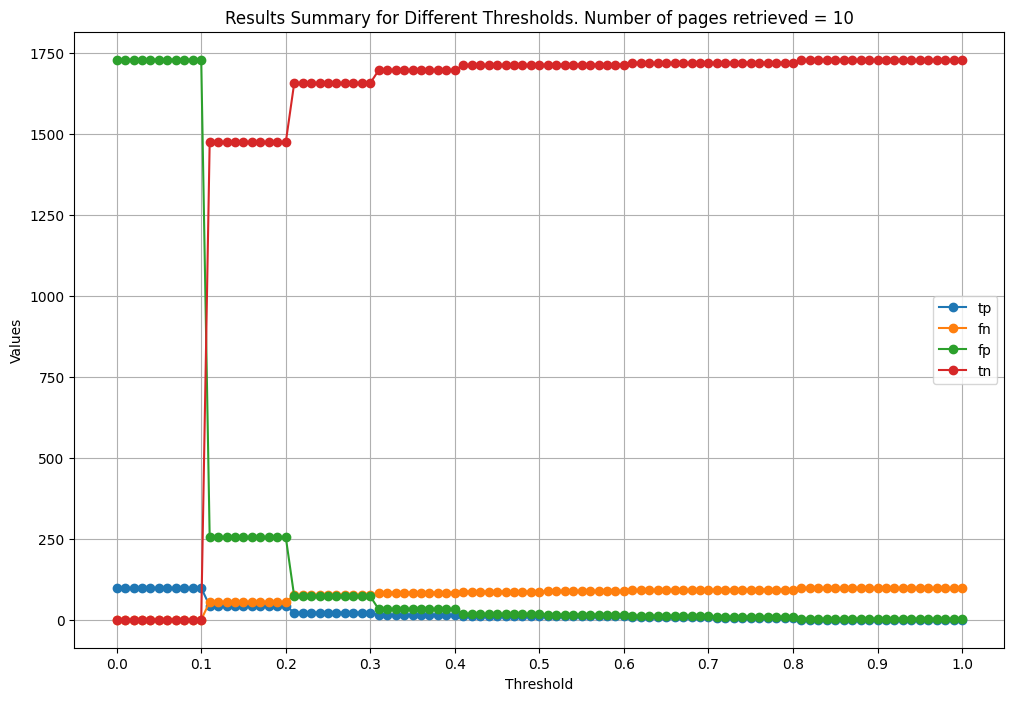

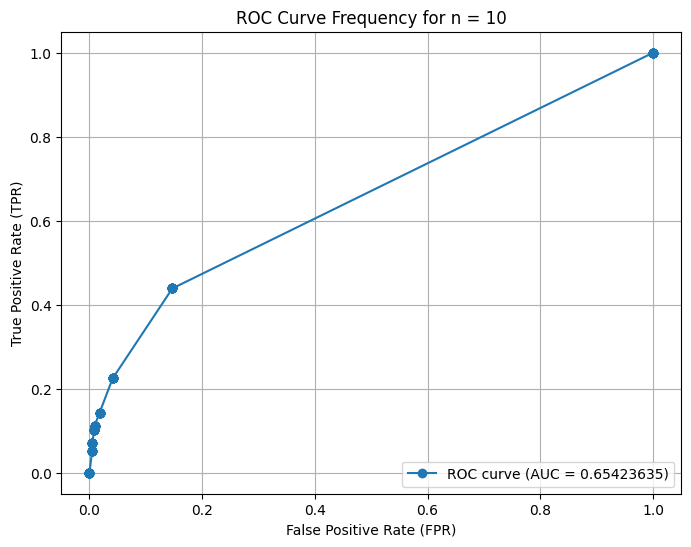

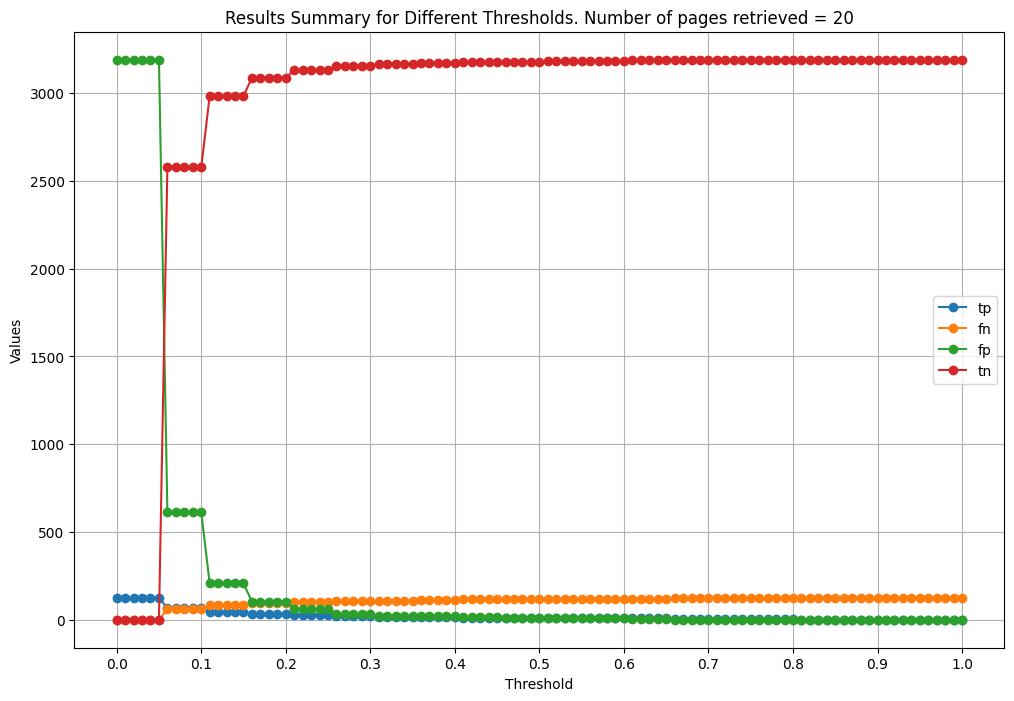

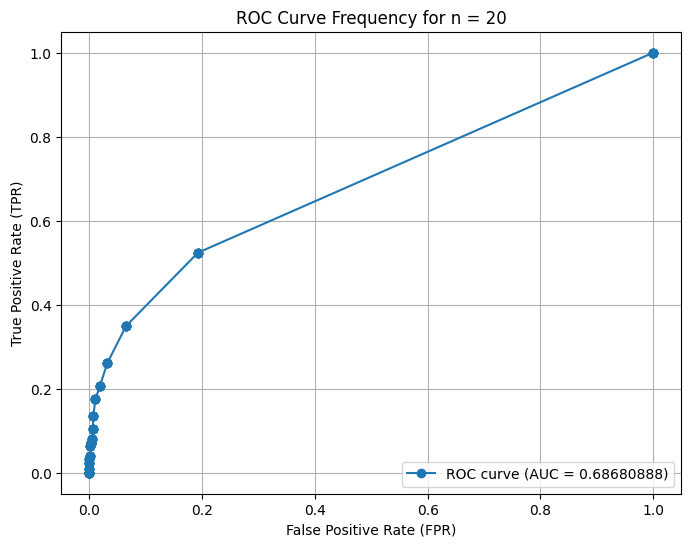

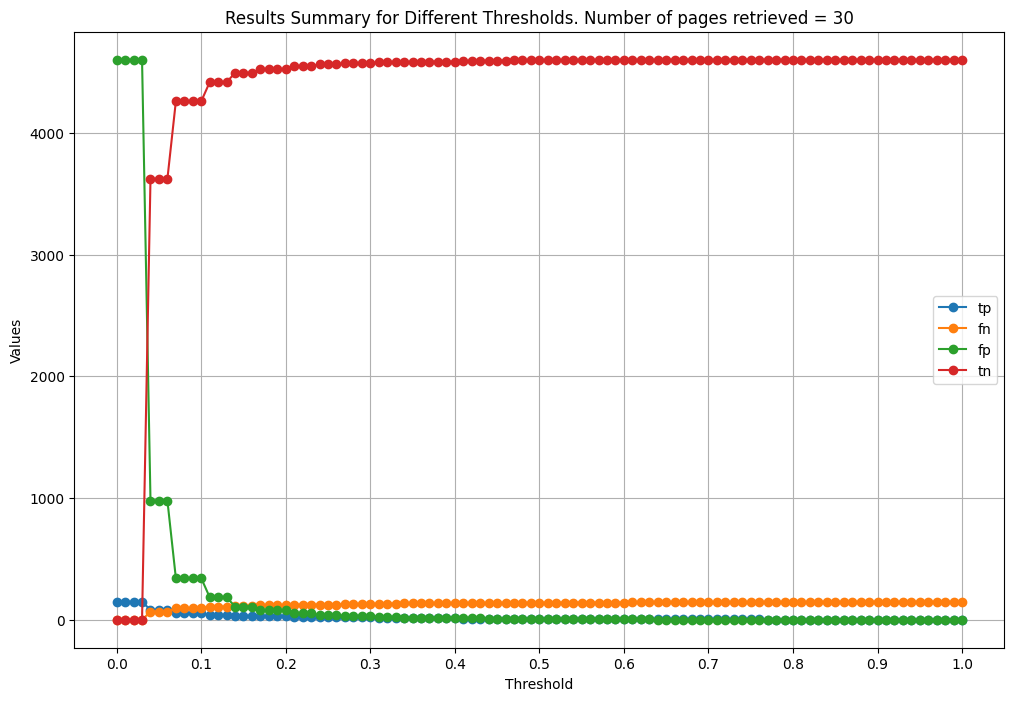

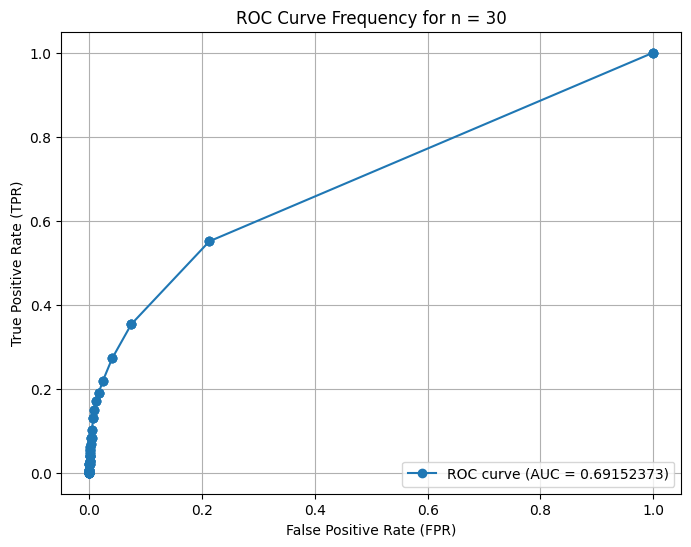

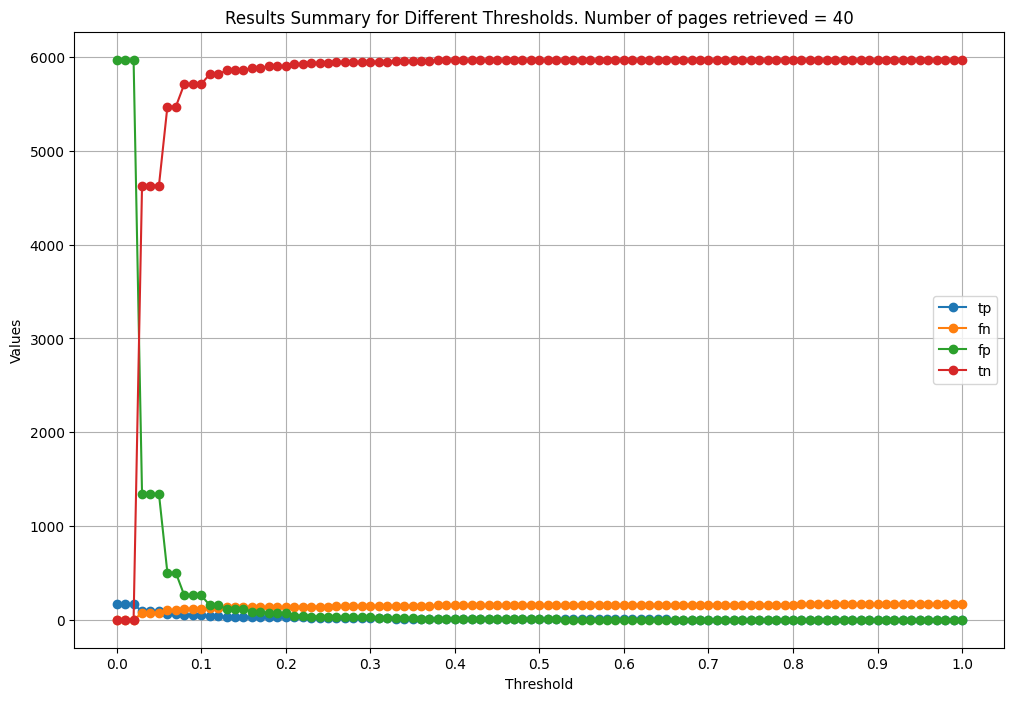

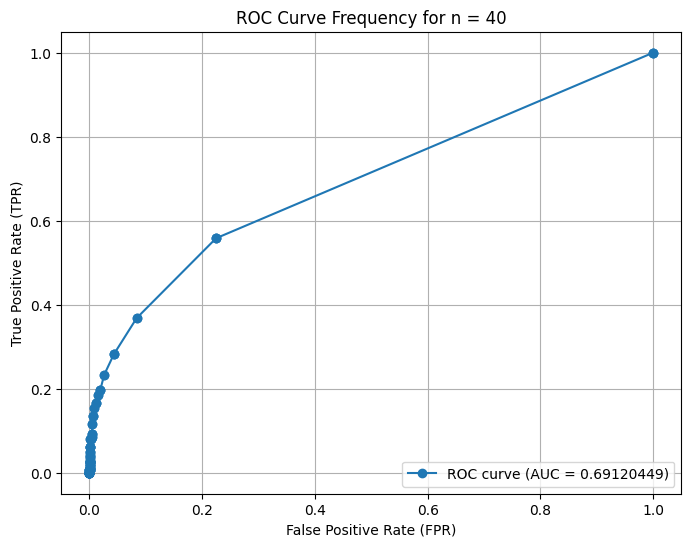

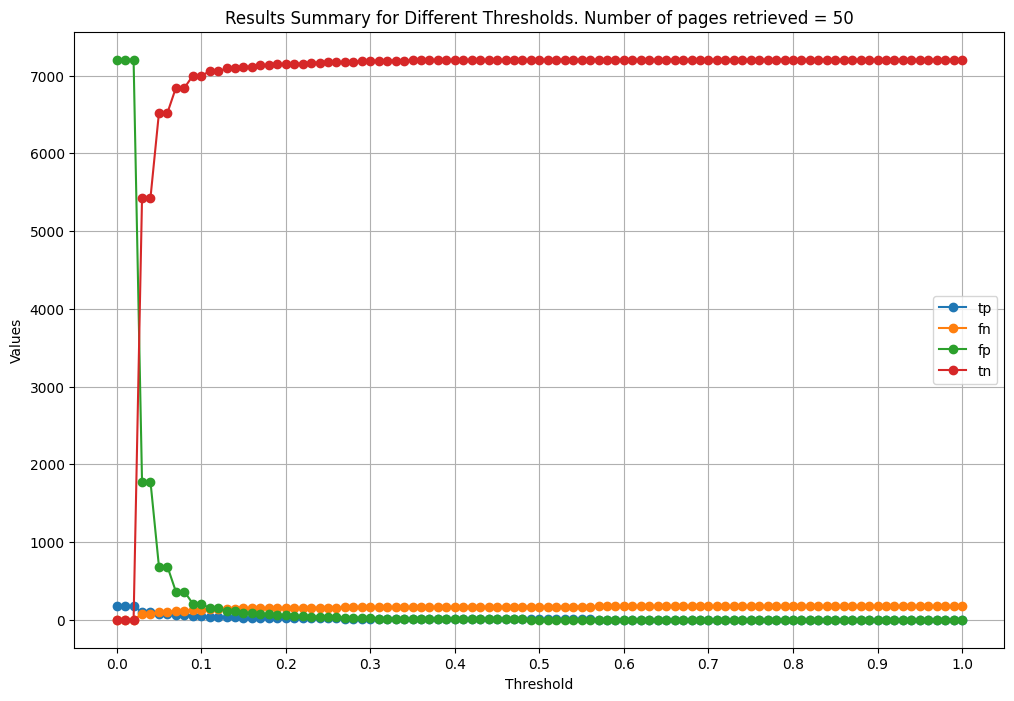

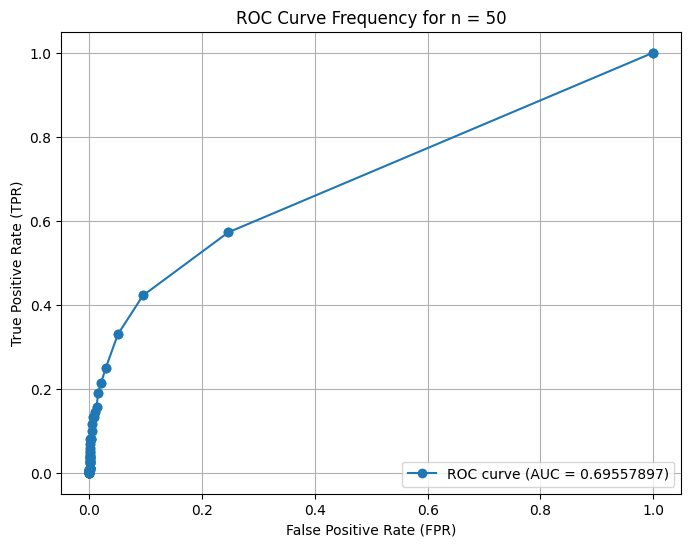

KeyboardInterrupt: 

In [3]:
dossier_id_limits = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# thresholds = [i/100 for i in range(101)]

# Normal
for i in dossier_id_limits:
    result = process_average(i)
    results_df = pd.DataFrame(result)
    plt.figure(figsize=(12, 8))

    plt.plot(results_df['threshold'], results_df['tp'], marker='o', label='tp')
    plt.plot(results_df['threshold'], results_df['fn'], marker='o', label='fn')
    plt.plot(results_df['threshold'], results_df['fp'], marker='o', label='fp')
    plt.plot(results_df['threshold'], results_df['tn'], marker='o', label='tn')
    
    plt.title(f'Results Summary for Different Thresholds. Number of pages retrieved = {i}')
    plt.xlabel('Threshold')
    plt.ylabel('Values')
    plt.xticks(thresholds)
    plt.grid(True)
    plt.legend()

    save_path = os.path.join(SAVE_FOLDER, f"frequency_{RESULTS_FILE.split('.')[0]}_{i}.png")
    # plt.savefig(save_path)
    plt.show()

# ROC
    # Calculate TPR and FPR
    tpr = [d['tp'] / (d['tp'] + d['fn']) for d in result]
    fpr = [(d['fp'] / (d['fp'] + d['tn']) if (d['fp'] + d['tn']) != 0 else 0) for d in result]

    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, marker='o', label=f'ROC curve (AUC = {roc_auc:.8f})')
    plt.title(f'ROC Curve Frequency for n = {i}')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.grid(True)

    # Add legend
    plt.legend(loc='lower right')

    save_path = os.path.join(SAVE_FOLDER, f"frequency_roc_{RESULTS_FILE.split('.')[0]}_{i}.png")
    # plt.savefig(save_path)
    plt.show()